# Tutoral For Quantum Chemistry

## 2019-11-08 @ PCL


![jupyter](linux.jpeg)

In [106]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution
from projectq.ops import CNOT, H, Rz, Rx, Ry, X, Z, Y
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
import numpy as np

In [107]:
raw_data_table_1 = np.loadtxt("H2_hamiltonians.txt")
target_energies = np.loadtxt("H2_gs_energy.txt")

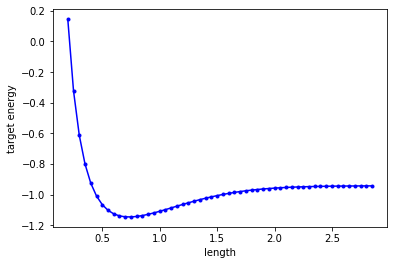

In [108]:
bond_lengths = [k[0] for k in raw_data_table_1];

plt.xlabel("length")
plt.ylabel("target energy")
plt.plot(bond_lengths, target_energies, "b.-")
plt.show()

In [123]:
def vqe(theta, hamiltonian):
    """ This is the function you need to test your parameterized quantum circuit.
    Args:
        theta (list): parameters
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the wavefunction for parameters theta
    """
    
    try:
        len(theta)
    except:
        theta = [theta]

    
    # Initialize the energy
    energy = 0
    eng = projectq.MainEngine()
    qubits = eng.allocate_qureg(2)
    
# Here you can add your circuit

### ================================================
#     # Initialize the Hartree Fock state |111>
#     X | qubits[0]
    
#     Rx(theta[0]) | qubits[0]
#     Rx(theta[1]) | qubits[1]
    
#     Rx(-np.pi/2) | qubits[0]
#     Ry(np.pi/2) | qubits[1]
#     CNOT |  (qubits[1],qubits[0])
    
#     Rz(theta[2]) | qubits[0]

#     CNOT |  (qubits[1],qubits[0])
    
#     Rx(np.pi/2) | qubits[0]
#     Ry(-np.pi/2) | qubits[1]
    
#     Rz(theta[3]) | qubits[0]
### ================================================

    X | qubits[0]
    
    Rx(-np.pi/2) | qubits[0]
    Ry(np.pi/2) | qubits[1]
    CNOT |  (qubits[1],qubits[0])
    
    Rz(theta[0]) | qubits[0]

    CNOT |  (qubits[1],qubits[0])
    
    Rx(np.pi/2) | qubits[0]
    Ry(-np.pi/2) | qubits[1]
    
### ================================================
    
#     X | qubits[0]
    
#     ansatz_op = QubitOperator('X0 Y1')
#     # Apply the unitary e^{-i * ansatz_op * t}
#     TimeEvolution(theta[0], ansatz_op) | qubits
    
    
    eng.flush()
    energy = eng.backend.get_expectation_value(hamiltonian, qubits)
    All(Measure) | qubits
    return energy

In [124]:
lowest_energies = []
bond_distances = []
    
for i in range(len(raw_data_table_1)):
    bond_distances.append(raw_data_table_1[i][0])
    hamiltonian = raw_data_table_1[i][1] * QubitOperator(())
    hamiltonian += raw_data_table_1[i][2] * QubitOperator("Z0")
    hamiltonian += raw_data_table_1[i][3] * QubitOperator("Z1")
    hamiltonian += raw_data_table_1[i][4] * QubitOperator("Z0 Z1")
    hamiltonian += raw_data_table_1[i][5] * QubitOperator("X0 X1")
    hamiltonian += raw_data_table_1[i][6] * QubitOperator("Y0 Y1")
    theta = [0] * 4
    minimum = minimize(vqe, theta, args = (hamiltonian))
    lowest_energies.append(minimum.fun)

In [125]:
print(sum(np.abs(np.array(lowest_energies) - np.array(target_energies))))
print()
if sum(np.abs(np.array(lowest_energies) - np.array(target_energies))) <= 0.001:
    score = 100
print ('Your score of problem3 is: {}'.format(score))

1.5666076769171866e-10

Your score of problem3 is: 100


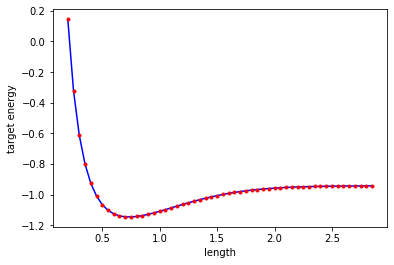

In [126]:
plt.xlabel("length")
plt.ylabel("target energy")
plt.plot(bond_lengths, target_energies, "b-")
plt.plot(bond_lengths, lowest_energies, "r.")

plt.show()

## define some fuinctions

In [127]:
def loss_H_H2(theta,config_H):
    
    hamiltonian = config_H[1] * QubitOperator(())  # == identity
    hamiltonian += config_H[2] * QubitOperator("Z0")
    hamiltonian += config_H[3] * QubitOperator("Z1")
    hamiltonian += config_H[4] * QubitOperator("Z0 Z1")
    hamiltonian += config_H[5] * QubitOperator("X0 X1")
    hamiltonian += config_H[6] * QubitOperator("Y0 Y1")
    
    return vqe(theta,hamiltonian)

In [128]:
def grad_H_H2(theta,config_H):
    d1=np.pi/2
    g1 = (loss_H_H2(theta+d1,config_H)-loss_H_H2(theta-d1,config_H))/2
    
    return g1

## Check ground energy as function of theta

In [129]:
a = np.arange(-np.pi,np.pi,0.1)

raw_data_hamiltonian = np.array(raw_data_table_1)
config_h = raw_data_hamiltonian[15,:]

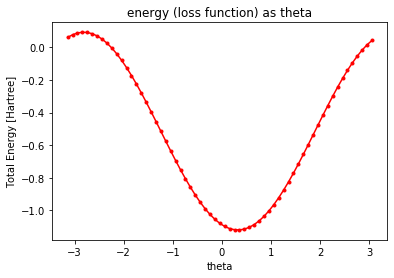

In [130]:

e_temp = []
for i in range(a.shape[0]):
    e_temp.append([loss_H_H2(a[i],config_h)])
        
plt.xlabel("theta")
plt.ylabel("Total Energy [Hartree]")
plt.plot(a, e_temp, "r.-")
plt.title("energy (loss function) as theta")
plt.show()

## Solve VQE

In [131]:
VQE_energies = []
VQE_thetas=[]

for i in range(len(raw_data_hamiltonian)):
    
    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    
    # See documentation of Scipy for different optimizers.
    config_H = raw_data_hamiltonian[i,:]
    
    theta = 0
    minimum = minimize(loss_H_H2, theta, args = (config_H))

#     minimum = minimize_scalar(lambda theta: loss_H_H2(theta,config_H))

    VQE_energies.append(minimum.fun)
    VQE_thetas.append(minimum.x)
    
    if (i+1)%10 == 0:
        print("i=",i,"\t VQE_theta=",minimum.x)
        
VQE_thetas = np.array(VQE_thetas)
        

i= 9 	 VQE_theta= [0.19131401]
i= 19 	 VQE_theta= [0.45037408]
i= 29 	 VQE_theta= [0.85863219]
i= 39 	 VQE_theta= [1.22398388]
i= 49 	 VQE_theta= [1.42336612]


In [118]:
minimum

      fun: -0.9429725037788301
 hess_inv: array([[0.84768131]])
      jac: array([-3.04728746e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([-0.73388886])

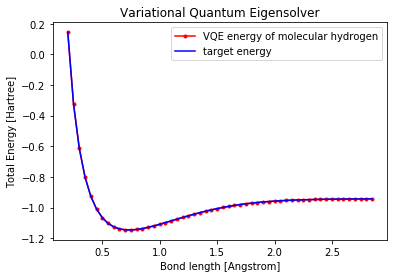

In [132]:
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Variational Quantum Eigensolver")
plt.plot(bond_lengths, VQE_energies, "r.-",
         label="VQE energy of molecular hydrogen")
plt.plot(bond_lengths, target_energies, "b-",
         label="target energy")
plt.legend()
plt.show()

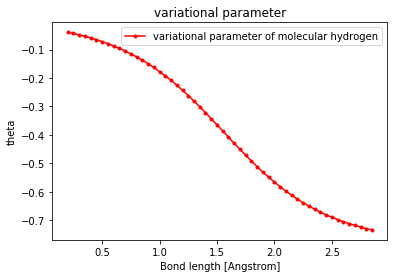

In [120]:
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("theta")
plt.title("variational parameter")
plt.plot(bond_lengths, VQE_thetas, "r.-",
         label="variational parameter of molecular hydrogen")
plt.legend()
plt.show()

In [137]:
def gs_energy(config_H,learning_rate=1e-1,t_steps=50,stop_e=1e-2):
    theta=0.1
    i=0
  #  change=1
    for i in range(t_steps):
        #theta_temp=theta
        theta=theta - learning_rate * grad_H_H2(theta,config_H)
        #change=abs(theta-theta_temp)
#         if i%10 ==0:
#             print('i= ',i, 'theta = ', theta)
        
    return theta,loss_H_H2(theta,config_H)

In [138]:
GD_energies = []
thetas=[]
for i in range(len(raw_data_hamiltonian)):
    
    theta,energy = gs_energy(raw_data_hamiltonian[i,:])
    GD_energies.append(energy)
    thetas.append(theta)

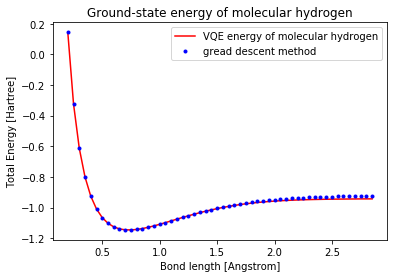

In [139]:
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Ground-state energy of molecular hydrogen")
plt.plot(bond_lengths, VQE_energies, "r-",
         label="VQE energy of molecular hydrogen")
plt.plot(bond_lengths, GD_energies, "b.",
         label="gread descent method")
#plt.plot(bond_distances, raw_data_table_1[:,1], "r.-",
#         label="constant term")
plt.legend()
plt.show()

# Let's try something else
## molecular LiH

In [65]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X
from projectq.ops import CNOT, H, Rz, Rx, Ry, X, Z, Y
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import numpy as np
from numpy.linalg import norm

In [72]:
config_Hs= np.loadtxt("coeff_hams_more.txt")[1:-2,:]
bond_lengths=np.loadtxt("spacings_more.txt")[1:-2]
real_energies=np.loadtxt("gs_energies_more.txt")[1:-2]
real_thetas=np.loadtxt("thetas_more.txt")[1:-2]
n_samples,n_features=config_Hs.shape
operator_list=[(),"Z0","Z1","Z2", "Y0 Y1", "X0 X1","Y0 Y2", "X0 X2", "Z0 Z1","Z0 Z2", "Y1 Y2", "X1 X2", "Z1 Z2"]

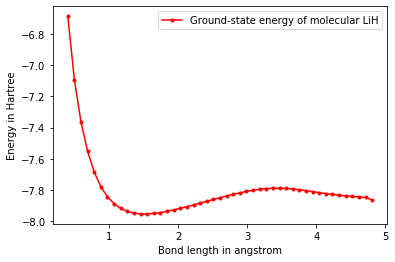

In [73]:
plt.figure(0)
plt.plot(bond_lengths, real_energies, "r.-",
         label="Ground-state energy of molecular LiH")

plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

In [74]:
def ham_LiH(config_H):
    #bond_distances.append(config_H[i,0])
    hamiltonian=config_H[0]*QubitOperator(operator_list[0])
    for j in range(1,n_features):
        hamiltonian+=config_H[j]*QubitOperator(operator_list[j])    
    return hamiltonian

hams = [ham_LiH(conf) for index, conf in enumerate(config_Hs)]

In [76]:
def variational_quantum_eigensolver(theta, hamiltonian):
    """
    Args:
        theta (float): variational parameter for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the wavefunction for parameter theta
    """
    # Create a ProjectQ compiler with a simulator as a backend
    eng = projectq.MainEngine()
    # Allocate 3 qubits in state |00>
    wf = eng.allocate_qureg(3)
    # Initialize the Hartree Fock state |111>
    X | wf[0]
    X | wf[1]
    X | wf[2]
    
    Rx(-np.pi/2) | wf[0]
    Ry(np.pi/2) | wf[1]
    CNOT |  (wf[0],wf[1])
    
    Rz(theta[0]) | wf[1]

    CNOT |  (wf[0],wf[1])
    Rx(np.pi/2) | wf[0]
    Ry(-np.pi/2) | wf[1]
    
    ########
    Rx(-np.pi/2) | wf[1]
    Ry(np.pi/2) | wf[2]
    CNOT |  (wf[2],wf[1])
    
    Rz(theta[1]) | wf[1]

    CNOT |  (wf[2],wf[1])
    Rx(np.pi/2) | wf[1]
    Ry(-np.pi/2) | wf[2]

    # flush all gates
    eng.flush()
    # Calculate the energy.
    # The simulator can directly return expectation values, while on a
    # real quantum devices one would have to measure each term of the
    # Hamiltonian.
    energy = eng.backend.get_expectation_value(hamiltonian, wf)
    # Measure in order to return to return to a classical state
    # (as otherwise the simulator will give an error)
    All(Measure) | wf
    return energy

def loss_H(theta,config_H):
     
    hams = ham_LiH(config_H)
    
    return variational_quantum_eigensolver(theta,hams)

In [77]:
a = np.arange(-0.5,4,0.1)
b = np.arange(-0.5,4,0.1)
aa, bb = np.meshgrid(a, b) 

config_h = config_Hs[5,:]

e_temp = np.zeros([a.shape[0],b.shape[0]])
for i in range(a.shape[0]):
    for j in range(b.shape[0]):
        e_temp[i,j] = loss_H([a[i],b[j]],config_h)
    if (i+1)%10 == 0:
        print("i=",i)

i= 9
i= 19
i= 29
i= 39


In [78]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

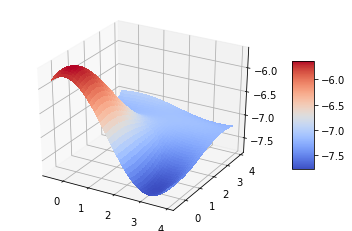

In [79]:
fig = plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.

# Plot the surface.
surf = ax.plot_surface(aa,bb, e_temp, cmap=cm.coolwarm,linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()

In [83]:
VQE_energies = []
thetas=[]
for i in range(len(bond_lengths)):
    
    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    
    # See documentation of Scipy for different optimizers.
    config_H = config_Hs[i,:]
#     minimum = minimize_scalar(lambda theta: ,[0.5,0.5])
    minimum = minimize(lambda theta: loss_H(theta,config_H), [0.5,0.5],method='nelder-mead',
               options={'xtol': 1e-5})
    VQE_energies.append(minimum.fun)
    thetas.append(minimum.x)
    if (i+1)%10 == 0:
        print("i=",i,"\t theta=",minimum.x)
        
        
    
# np.savetxt("VQE_energies.txt",np.array(VQE_energies))

i= 9 	 theta= [-0.02722786  3.14128681]
i= 19 	 theta= [-0.07483854  3.14092601]
i= 29 	 theta= [-0.41084603  3.13878451]
i= 39 	 theta= [-1.24616854  3.14229917]


## note that VQE 6-qubit Hamiltonian is different from full Hamiltonian result

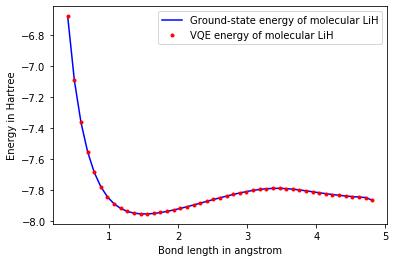

In [86]:
%matplotlib inline
plt.figure()

plt.plot(bond_lengths, real_energies, "b-",
         label="Ground-state energy of molecular LiH")
plt.plot(bond_lengths, VQE_energies, "r.",
         label="VQE energy of molecular LiH")

plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

## Theta[0] is almost 3.14 ( 𝜋 ) forever. Perhaps single theta is engouth

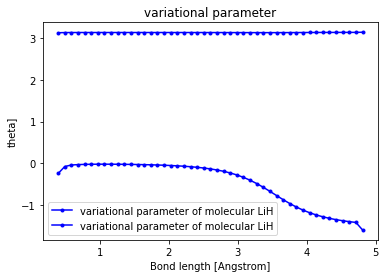

In [87]:
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("theta]")
plt.title("variational parameter")
plt.plot(bond_lengths, thetas, "b.-",
         label="variational parameter of molecular LiH")
plt.legend()
plt.show()

# Normal grad descent
### choosing init theta = [0,$\pi$],get the same results as VQE

In [88]:
def grad(theta,config_H):
    d=np.pi/2
    d1=np.array([d,0])
    d2=np.array([0,d])
    g1 = (loss_H(theta+d1,config_H)-loss_H(theta-d1,config_H))/2
    g2 =(loss_H(theta+d2,config_H)-loss_H(theta-d2,config_H))/2
    return np.array([g1,g2])

def GS_energy(config_H,learning_rate=1e-1,t_steps=300):
#     theta=0.2*np.random.rand(2)
    theta=np.array([1,3])
    i=0
  #  change=1
    thetas=[]
    for i in range(t_steps):
        #theta_temp=theta
        theta=theta - learning_rate*grad(theta,config_H)
        #change=abs(theta-theta_temp)
#         if (i+1)%5==0:
#             print(loss_H(theta,config_H))
        thetas.append(theta)
        
    return thetas,loss_H(theta,config_H)

In [89]:
GD_energies = []
theta_history=[]
for i in range(config_Hs.shape[0]):
    # Use data of paper to construct the Hamiltonian

    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    
    # See documentation of Scipy for different optimizers.
    config_H = config_Hs[i,:]
    thetas,energy=GS_energy(config_H)
    GD_energies.append(energy)
    theta_history.append(thetas)
    print(energy)

# np.savetxt("GD_energies.txt",np.array(GD_energies))

-6.678879029582526
-7.090683724597336
-7.363103530517664
-7.55198310083538
-7.6848534277266625
-7.778272609674011
-7.843417222041351
-7.888158239903729
-7.918066537416001
-7.937088760173457
-7.948041543550693
-7.95296102762909
-7.953341435515261
-7.950295798122785
-7.944664749255722
-7.937091214368201
-7.9280727968196265
-7.91799949441324
-7.907181631185888
-7.8958711268655595
-7.884278144939551
-7.872584528222365
-7.860955074176618
-7.849547489503998
-7.838521683031197
-7.8280487903307865
-7.818319710003862
-7.809552222391073
-7.80199354124696
-7.795913389987509
-7.791580711281883
-7.7892188338245285
-7.788943130263069
-7.790701250882208
-7.794249003686896
-7.799169537760542
-7.804983758471329
-7.8112100645773594
-7.817448491824297
-7.823415188932641
-7.828927621227867
-7.833897007632914
-7.83829715142764
-7.842143546836914
-7.8454753494332925
-7.84834532092119
-7.865122063885333


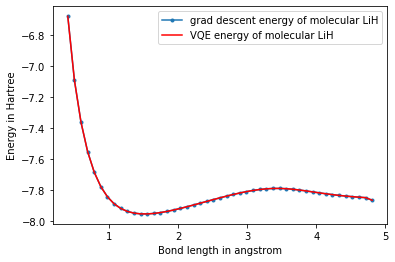

In [93]:
%matplotlib inline
plt.figure()
plt.plot(bond_lengths, GD_energies, ".-",
         label="grad descent energy of molecular LiH")
plt.plot(bond_lengths, VQE_energies, "r-",
         label="VQE energy of molecular LiH")

plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()